In [0]:
#@title Copyright 2019 The Empirical Calibration Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

# Causal Inference of Kang-Schafer simulation.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/empirical_calibration/blob/master/notebooks/causal_inference_kang_schafer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/empirical_calibration/blob/master/notebooks/causal_inference_kang_schafer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

>[Causal Inference of Kang-Schafer simulation.](#scrollTo=RYsS3JrpHaJI)

>>[Imports](#scrollTo=VGDMBD7TRIf4)

>>[Correctly Specified Model](#scrollTo=X1D4OBiEZhnT)

>>[Misspecified Model](#scrollTo=0zuCvTGVdMVj)

>>[Benchmark Execution Time](#scrollTo=ITCnSqDiyjIx)



We illustrate empirical calibration to estimate the average treatment effect on the treated (ATT) on Kang-Schafer simulation under both correctly specified and misspecified models, and benchmark the execution time.  For details of simulation setup, please refer to [kang_schafer_population_mean.ipynb](./kang_schafer_population_mean.ipynb).

## Imports

In [0]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import patsy
import seaborn as sns
import timeit

# install and import ec
!pip install -q git+https://github.com/google/empirical_calibration
import empirical_calibration as ec

sns.set_style('whitegrid')
%config InlineBackend.figure_format='retina'


## Correctly Specified Model

We run the simulation 1000 times under correctly specified logistic propensity score and linear outcome regression. For each simulation we estimate the average treatment effect on the treated (ATT) using empirical calibration.

In [0]:
def estimate_att(formula):
  simulation = ec.data.kang_schafer.Simulation(size=1000)

  t = simulation.treatment
  y = simulation.outcome

  df = pd.DataFrame(
      np.column_stack(
          [simulation.covariates, simulation.transformed_covariates]))
  df.columns = ["z1", "z2", "z3", "z4", "x1", "x2", "x3", "x4"]
  x = patsy.dmatrix(formula, df, return_type="dataframe").values


  weights = ec.maybe_exact_calibrate(covariates=x[t == 0],
                                     target_covariates=x[t == 1])[0]

  return (np.mean(y[t == 1]) - np.mean(y[t == 0]),
          np.mean(y[t == 1]) - np.sum(y[t == 0] * weights))


def show_estimates(estimates, col='weighted'):
  ax = estimates[col].hist(bins=20, alpha=0.8, edgecolor='none')
  plt.axvline(estimates[col].mean(), linestyle='dashed', color='red')
  print('bias of {} is {}'.format(col, estimates[col].mean()))
  print('rmse of {} is {}'.format(col, np.sqrt(np.mean((estimates[col] - 0.) ** 2))))

In [0]:
estimates = pd.DataFrame(
    [estimate_att("-1 + z1 + z2 + z3 + z4") for i in xrange(1000)])
estimates.columns = ['raw', 'weighted']

The mean of the 1000 ATT estimates after weight correction is very close to the true zero ATT.

bias of raw is -19.9628369399
rmse of raw is 20.0889440518


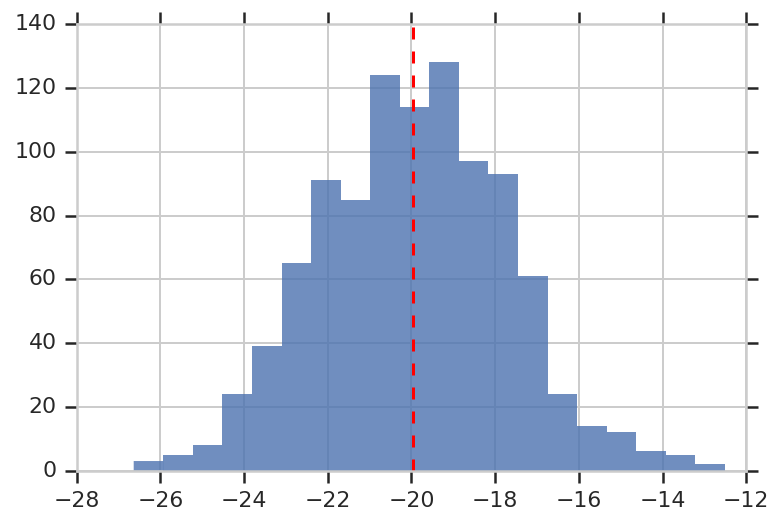

In [5]:
show_estimates(estimates,'raw')

bias of weighted is 0.00108065962091
rmse of weighted is 0.0854238555451


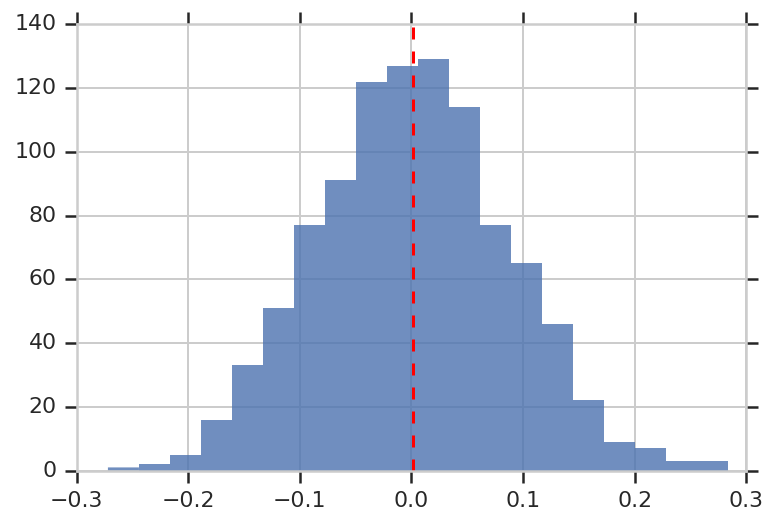

In [6]:
show_estimates(estimates,'weighted')

## Misspecified Model

If the transformed covariates are observed in place of the true covariates, both the propensity score model and outcome regression model become misspecified. We run 1000 simulations and for each simulation estimate the ATT by balancing the transformed covariates. The causal estimate is no longer unbiased.

In [0]:
estimates_miss = pd.DataFrame([estimate_att("-1 + x1 + x2 + x3 + x4") for i in xrange(1000)])
estimates_miss.columns = ['raw', 'weighted']

bias of weighted is -4.37849137373
rmse of weighted is 4.50105698077


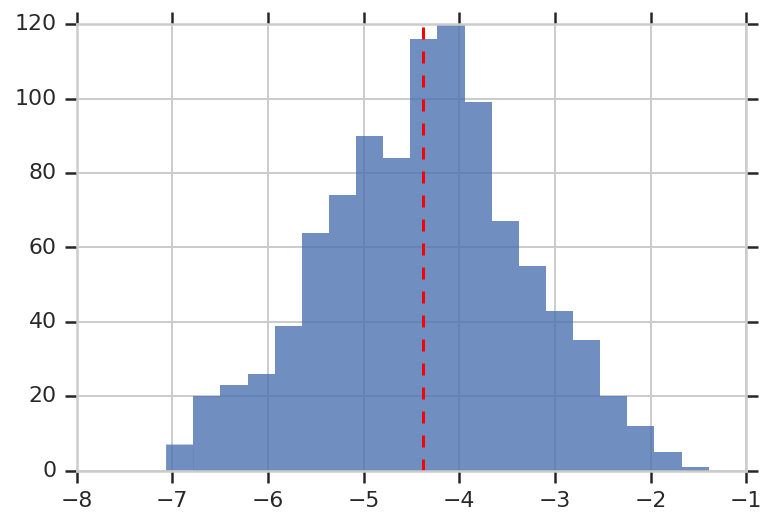

In [8]:
show_estimates(estimates_miss)

One reasonable strategy is to expand the set of balancing covariates and hope it will make the model less "misspecified". If we additional balance the two-way interactions and the log transformation, the bias indeed reduces.

In [0]:
formula = ("-1 + (x1 + x2 + x3 + x4)**2 + I(np.log(x1)) + I(np.log(x2)) + "
           "I(np.log(x3)) + I(np.log(x4))")

estimates_expanded = pd.DataFrame([estimate_att(formula) for i in xrange(1000)])
estimates_expanded.columns = ['raw', 'weighted']

bias of weighted is -1.88003551222
rmse of weighted is 2.07831395567


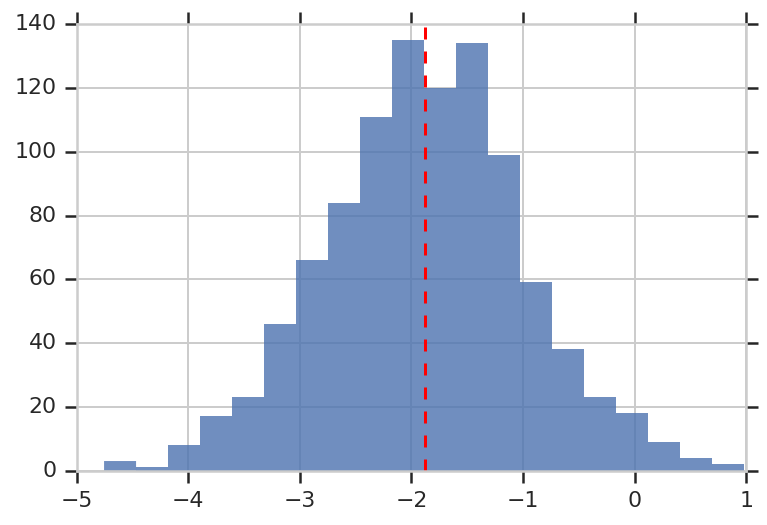

In [10]:
show_estimates(estimates_expanded)

If the model was misspecified in the sense that more covariates are included than necessary, the causal estimate remains unbiased.

In [0]:
formula = "-1 + z1 + z2 + z3 + z4 + x1 + x2 + x3 + x4"
estimates_redundant = pd.DataFrame([estimate_att(formula) for i in range(1000)])
estimates_redundant.columns = ['raw', 'weighted']

bias of weighted is -0.00229483538445
rmse of weighted is 0.0891054715229


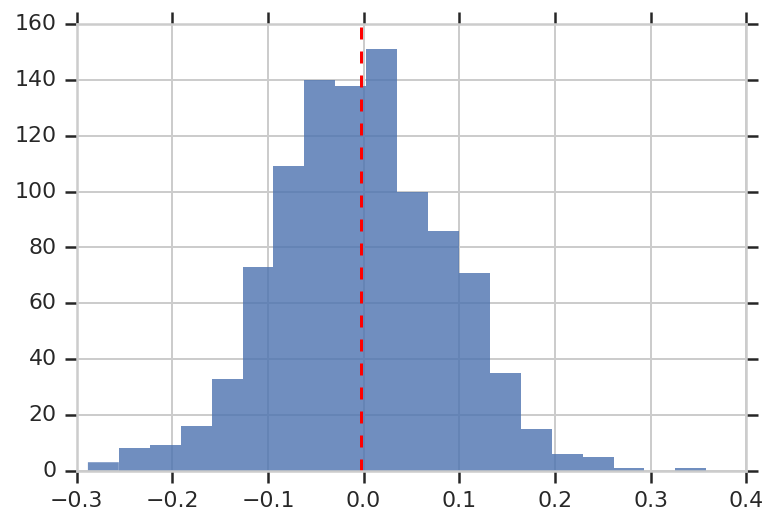

In [12]:
show_estimates(estimates_redundant)

## Benchmark Execution Time

The execution time is generally linear with respect to the sample size. With 1 million control units, it takes around 1 second to find the weights.

In [13]:
np.random.seed(123)
simulation = ec.data.kang_schafer.Simulation(size=2000)
x1 = simulation.covariates[simulation.treatment == 1]
x0 = simulation.covariates[simulation.treatment == 0]
pd.Series(timeit.repeat(
    'ec.maybe_exact_calibrate(x0, x1)',
    setup='from __main__ import x1, x0, ec',
    repeat=100,
    number=1)).describe()

count    100.000000
mean       0.001823
std        0.000230
min        0.001637
25%        0.001699
50%        0.001750
75%        0.001873
max        0.003199
dtype: float64

In [14]:
np.random.seed(123)
simulation = ec.data.kang_schafer.Simulation(size=20000)
x1 = simulation.covariates[simulation.treatment == 1]
x0 = simulation.covariates[simulation.treatment == 0]
pd.Series(timeit.repeat(
    'ec.maybe_exact_calibrate(x0, x1)',
    setup='from __main__ import x1, x0, ec',
    repeat=100,
    number=1)).describe()

count    100.000000
mean       0.010971
std        0.000702
min        0.010231
25%        0.010383
50%        0.010658
75%        0.011522
max        0.013335
dtype: float64